In [ ]:
# Cell 1: Imports & setup

import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import trange

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)


Using device: cuda


In [ ]:
# Cell 2: Hyperparameters (modular multiplication)

PRIME_P = 97          # modulus p (prime). You can change this.
TRAIN_FRAC = 0.3      # fraction of all (x,y) pairs used for training

SEQ_LEN = 3           # sequence = [x, y, '=']
VOCAB_SIZE = PRIME_P + 1   # tokens 0..p-1 plus '=' token at index p

D_MODEL = 128
N_HEADS = 4
DIM_FF = 512
NUM_LAYERS = 1        # 1-layer transformer encoder

LR = 1e-3
WEIGHT_DECAY = 1e-1   # start with 0.1; you can sweep later
NUM_STEPS = 50_000

LOG_EVERY = 100
SAVE_EVERY = 1_000

# e.g. Cell 5.5: which checkpoints to save for mech-interp
CHECKPOINT_STEPS = [100, 500, 1000, 5000, 10000, NUM_STEPS]

CKPT_DIR = "checkpoints_modmul_transformer"
os.makedirs(CKPT_DIR, exist_ok=True)

SEED = 0
set_seed(SEED)


In [ ]:
# Cell 3: Dataset generation for modular multiplication

def generate_modmul_dataset(p=97, train_frac=0.3, seed=0):
    """
    Enumerate all (x, y) in {0..p-1}^2.
    Input tokens: [x, y, eq_token]
    Label: (x * y) mod p
    """
    set_seed(seed)
    all_seqs = []
    all_labels = []

    EQ_TOKEN = p  # '=' token index

    for x in range(p):
        for y in range(p):
            seq = torch.tensor([x, y, EQ_TOKEN], dtype=torch.long)
            label = (x * y) % p
            all_seqs.append(seq)
            all_labels.append(label)

    X = torch.stack(all_seqs)        # [p^2, 3] long
    y = torch.tensor(all_labels)     # [p^2] long

    num_examples = X.shape[0]
    indices = list(range(num_examples))
    random.shuffle(indices)

    split_idx = int(train_frac * num_examples)
    train_idx = indices[:split_idx]
    test_idx  = indices[split_idx:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx], y[test_idx]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = generate_modmul_dataset(
    p=PRIME_P,
    train_frac=TRAIN_FRAC,
    seed=SEED
)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test,  y_test  = X_test.to(device), y_test.to(device)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Example X_train[0]:", X_train[0].tolist(), "→", y_train[0].item())

Train size: 2822
Test size: 6587
Example X_train[0]: [63, 40, 97] → 95


In [ ]:
# Cell 4: Modular multiplication transformer

class ModMulTransformer(nn.Module):
    def __init__(
        self,
        p=97,
        d_model=128,
        n_heads=4,
        dim_ff=512,
        num_layers=1,
        seq_len=3,
    ):
        super().__init__()
        self.p = p
        self.vocab_size = p + 1  # 0..p-1 plus '='
        self.d_model = d_model
        self.seq_len = seq_len

        self.token_emb = nn.Embedding(self.vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.out_proj = nn.Linear(d_model, p)  # logits over 0..p-1

    def forward(self, x_tokens):
        """
        x_tokens: [batch, seq_len] long
        """
        x = self.token_emb(x_tokens)                 # [B, L, D]
        x = x + self.pos_emb[:, :self.seq_len, :]    # add positions
        h = self.encoder(x)                          # [B, L, D]
        last = h[:, -1, :]                           # take '=' position
        logits = self.out_proj(last)                 # [B, p]
        return logits


model = ModMulTransformer(
    p=PRIME_P,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    dim_ff=DIM_FF,
    num_layers=NUM_LAYERS,
    seq_len=SEQ_LEN,
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

print(model)


ModMulTransformer(
  (token_emb): Embedding(98, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (out_proj): Linear(in_features=128, out_features=97, bias=True)
)


In [ ]:
# Cell 5: Utilities

def modmul_accuracy_from_logits(logits: torch.Tensor, labels: torch.Tensor) -> float:
    """
    logits: [batch, p]
    labels: [batch] long
    """
    preds = logits.argmax(dim=-1)
    acc = (preds == labels).float().mean().item()
    return acc


def evaluate(model, X_train, y_train, X_test, y_test):
    model.eval()
    with torch.no_grad():
        train_logits = model(X_train)
        test_logits  = model(X_test)

        train_loss = F.cross_entropy(train_logits, y_train).item()
        test_loss  = F.cross_entropy(test_logits,  y_test).item()

        train_acc = modmul_accuracy_from_logits(train_logits, y_train)
        test_acc  = modmul_accuracy_from_logits(test_logits,  y_test)

    return train_loss, test_loss, train_acc, test_acc


def save_checkpoint(model, step, ckpt_dir=CKPT_DIR):
    path = os.path.join(ckpt_dir, f"model_step{step}.pt")
    torch.save(model.state_dict(), path)
    return path


def plot_training_curves(steps, train_accs, test_accs, train_losses, test_losses, title_suffix=""):
    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.plot(steps, train_accs, label="train_acc")
    plt.plot(steps, test_accs, label="test_acc")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy {title_suffix}")

    plt.subplot(1, 2, 2)
    plt.plot(steps, train_losses, label="train_loss")
    plt.plot(steps, test_losses, label="test_loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss {title_suffix}")

    plt.tight_layout()
    plt.show()


In [ ]:
# ==== Cell 6: Training loop for modular multiplication (with grokking + loss turning detection) ====

from tqdm.auto import trange

# Heuristics / thresholds (tweak if you want)
TRAIN_THRESH   = 0.99   # train accuracy considered "essentially perfect"
TEST_THRESH    = 0.90   # test accuracy considered "good"
MIN_MEM_LOGS   = 5      # how many logs with high-train/low-test before we say "memorization phase"
MIN_INCREASE   = 0.0    # min delta to count as a real increase in test loss
MIN_DECREASE   = 0.0    # min delta to count as a real decrease in test loss

train_losses, test_losses = [], []
train_accs,  test_accs   = [], []
steps = []

# Grokking (accuracy-based) tracking
memorization_logs    = 0
memorization_started = False
grokking_step        = None

# Loss turning-point tracking
prev_test_loss = None
prev_diff      = None
loss_turn_step = None

print("Starting training...")

for step in trange(1, NUM_STEPS + 1):
    model.train()
    logits = model(X_train)
    loss = F.cross_entropy(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # ---- Logging block ----
    if step % LOG_EVERY == 0:
        train_loss, test_loss, train_acc, test_acc = evaluate(
            model, X_train, y_train, X_test, y_test
        )

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        steps.append(step)

        print(
            f"Step {step:6d} | "
            f"train_loss={train_loss:.4f} test_loss={test_loss:.4f} | "
            f"train_acc={train_acc:.3f} test_acc={test_acc:.3f}"
        )

        # ========= GROKKING DETECTION (ACCURACY-BASED) =========

        # Count "memorization logs": train high, test still low
        if train_acc >= TRAIN_THRESH and test_acc < TEST_THRESH:
            memorization_logs += 1

        # Memorization phase has started once we have enough such logs
        if memorization_logs >= MIN_MEM_LOGS:
            memorization_started = True

        # If we've been in memorization and now both train + test are high → grokking
        if (
            memorization_started
            and grokking_step is None
            and train_acc >= TRAIN_THRESH
            and test_acc >= TEST_THRESH
        ):
            grokking_step = step
            print(
                f"\n[💡 GROKKING DETECTED] At step {step}: "
                f"train_acc={train_acc:.3f}, test_acc={test_acc:.3f}\n"
            )
            # Save a checkpoint exactly at grokking
            path = save_checkpoint(model, step)
            print(f"[checkpoint] Saved GROKKING checkpoint at step {step} -> {path}")

        # ========= TEST LOSS TURNING POINT DETECTION =========
        # We look for a sign change in the test loss slope: up then down.

        if prev_test_loss is not None:
            diff = test_loss - prev_test_loss  # current slope
            if prev_diff is not None:
                # Previously increasing, now decreasing
                if (
                    prev_diff > MIN_INCREASE
                    and diff < -MIN_DECREASE
                    and loss_turn_step is None
                ):
                    loss_turn_step = step
                    print(
                        f"\n[📉 TEST LOSS TURNING POINT DETECTED] "
                        f"At step {step}: test_loss={test_loss:.4f}\n"
                    )
                    # Save a checkpoint exactly at turning point
                    path = save_checkpoint(model, step)
                    print(f"[checkpoint] Saved LOSS-TURN checkpoint at step {step} -> {path}")
            prev_diff = diff

        prev_test_loss = test_loss

    # ---- Regular periodic checkpointing (e.g. every SAVE_EVERY steps) ----
    if SAVE_EVERY is not None and step % SAVE_EVERY == 0:
        path = save_checkpoint(model, step)
        print(f"[checkpoint] Saved periodic checkpoint at step {step} -> {path}")

    # ---- Extra checkpoints specifically for pre-defined mechanistic analysis steps ----
    if step in CHECKPOINT_STEPS:
        path = save_checkpoint(model, step)
        print(f"[checkpoint] Saved CHECKPOINT_STEPS checkpoint at step {step} -> {path}")

# ========= After training: summarize grokking + loss turning =========

print("\n===== Training finished. Summary: =====")

if grokking_step is not None:
    print(f"  → Grokking detected at step {grokking_step}.")
else:
    print("  → No grokking detected under the current accuracy thresholds.")

if loss_turn_step is not None:
    print(f"  → Test loss turning point detected at step {loss_turn_step}.")
else:
    print("  → No clear test loss turning point detected under current settings.")

# ========= Build final analysis checkpoint list =========
# Include: user-specified CHECKPOINT_STEPS, grokking_step, loss_turn_step (if any)

extra_steps = []
if grokking_step is not None:
    extra_steps.append(grokking_step)
if loss_turn_step is not None:
    extra_steps.append(loss_turn_step - 100)
    extra_steps.append(loss_turn_step)
    extra_steps.append(loss_turn_step + 100)

CHECKPOINT_STEPS = sorted(set(list(CHECKPOINT_STEPS) + extra_steps))
print("\nANALYSIS_CHECKPOINT_STEPS =", CHECKPOINT_STEPS)
print("Use ANALYSIS_CHECKPOINT_STEPS in your 4.1–4.5 analysis cells.")

Starting training...


  0%|          | 0/50000 [00:00<?, ?it/s]

Step    100 | train_loss=2.2322 test_loss=6.1182 | train_acc=0.497 test_acc=0.022
[checkpoint] Saved CHECKPOINT_STEPS checkpoint at step 100 -> checkpoints_modmul_transformer/model_step100.pt
Step    200 | train_loss=0.1687 test_loss=7.9720 | train_acc=0.991 test_acc=0.031
Step    300 | train_loss=0.0397 test_loss=8.7881 | train_acc=0.995 test_acc=0.039
Step    400 | train_loss=0.0196 test_loss=9.2752 | train_acc=0.997 test_acc=0.046
Step    500 | train_loss=0.0107 test_loss=9.5938 | train_acc=0.998 test_acc=0.049
[checkpoint] Saved CHECKPOINT_STEPS checkpoint at step 500 -> checkpoints_modmul_transformer/model_step500.pt
Step    600 | train_loss=0.0064 test_loss=9.7867 | train_acc=0.999 test_acc=0.051
Step    700 | train_loss=0.0049 test_loss=9.9029 | train_acc=1.000 test_acc=0.052
Step    800 | train_loss=0.0028 test_loss=10.0390 | train_acc=1.000 test_acc=0.052
Step    900 | train_loss=0.0020 test_loss=10.1634 | train_acc=1.000 test_acc=0.057
Step   1000 | train_loss=0.0018 test_los

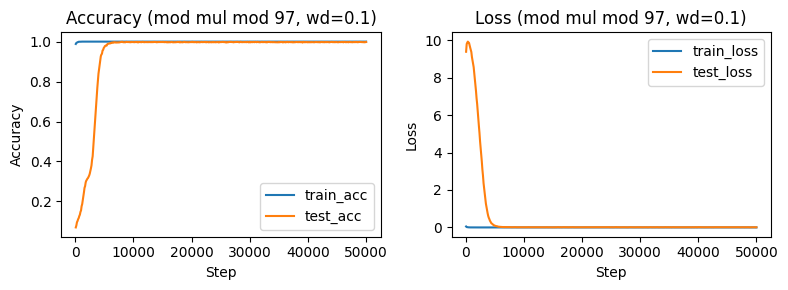

In [ ]:
# Cell 7: Plot curves

plot_training_curves(
    steps,
    train_accs,
    test_accs,
    train_losses,
    test_losses,
    title_suffix=f"(mod mul mod {PRIME_P}, wd={WEIGHT_DECAY})",
)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
from ipywidgets import interact, IntSlider

device = "cuda" if torch.cuda.is_available() else "cpu"

def load_checkpoint(step):
    path = os.path.join(CKPT_DIR, f"model_step{step}.pt")
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"Loaded checkpoint: {path}")

def get_hidden_states(model, X_tokens):
    model.eval()
    with torch.no_grad():
        x = model.token_emb(X_tokens)
        x = x + model.pos_emb[:, :X_tokens.size(1), :]
        h = x
        for layer in model.encoder.layers:
            h = layer(h)
    return h

Loaded checkpoint: checkpoints_modmul_transformer/model_step100.pt


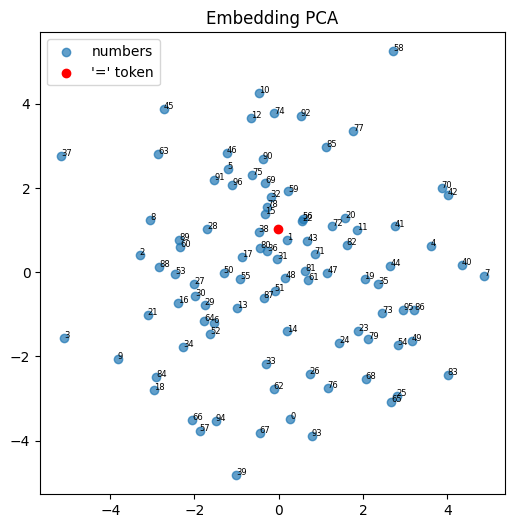

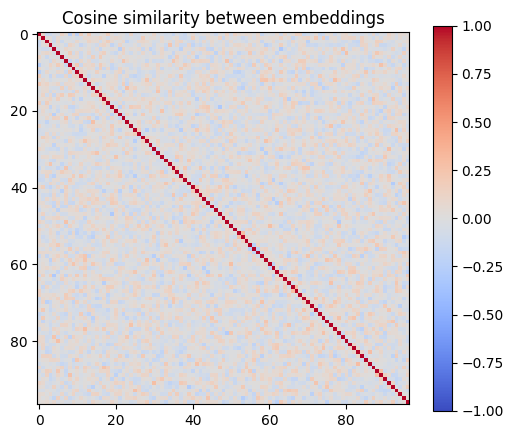

Loaded checkpoint: checkpoints_modmul_transformer/model_step500.pt


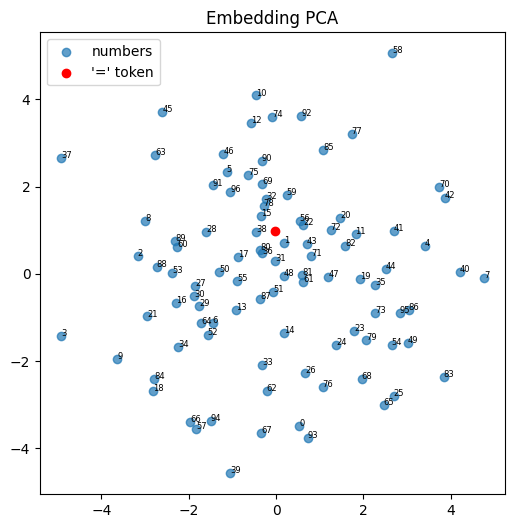

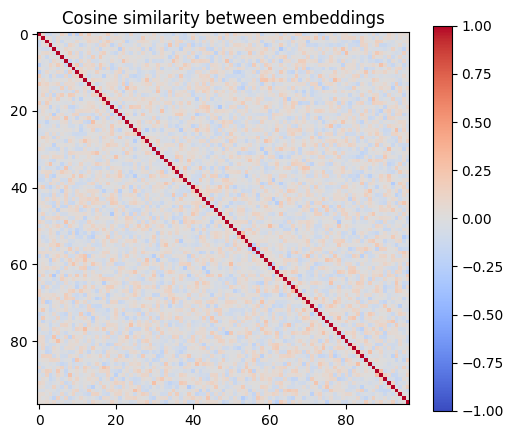

Loaded checkpoint: checkpoints_modmul_transformer/model_step1000.pt


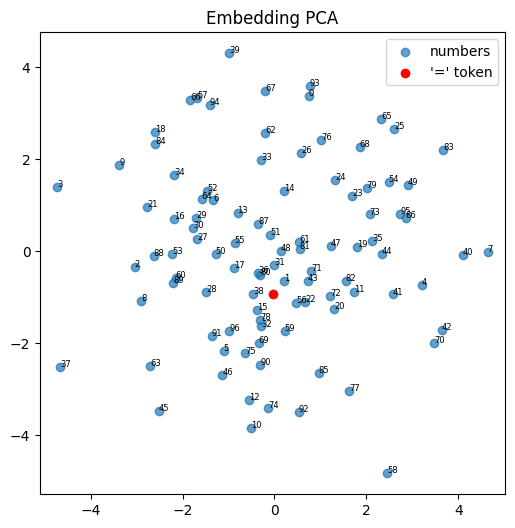

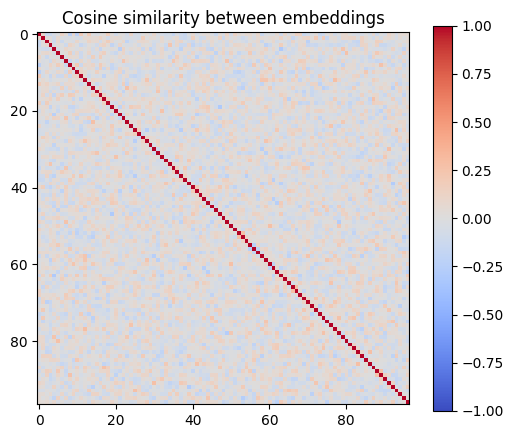

Loaded checkpoint: checkpoints_modmul_transformer/model_step4300.pt


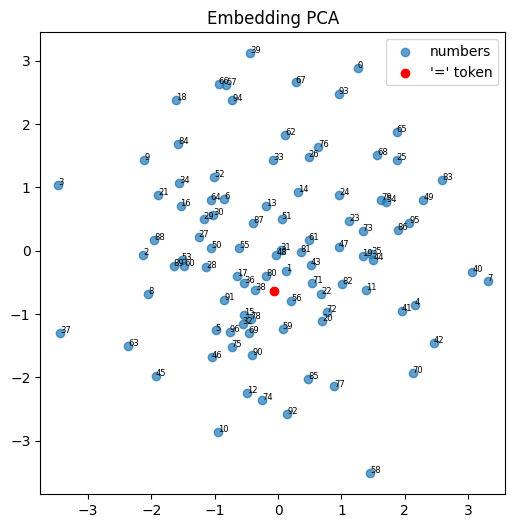

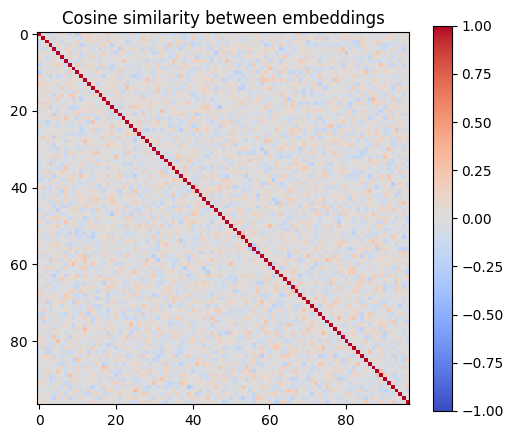

Loaded checkpoint: checkpoints_modmul_transformer/model_step5000.pt


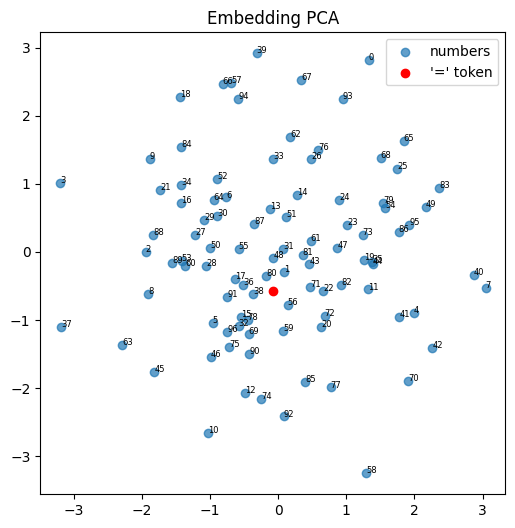

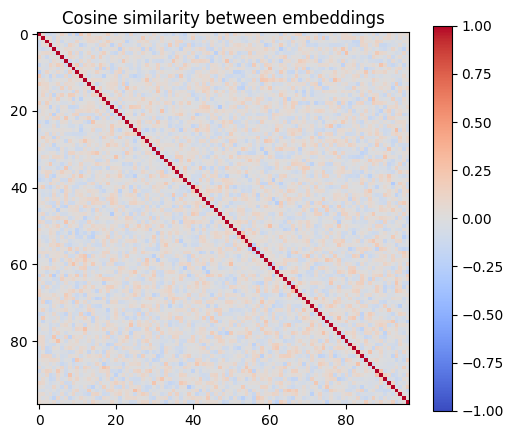

Loaded checkpoint: checkpoints_modmul_transformer/model_step10000.pt


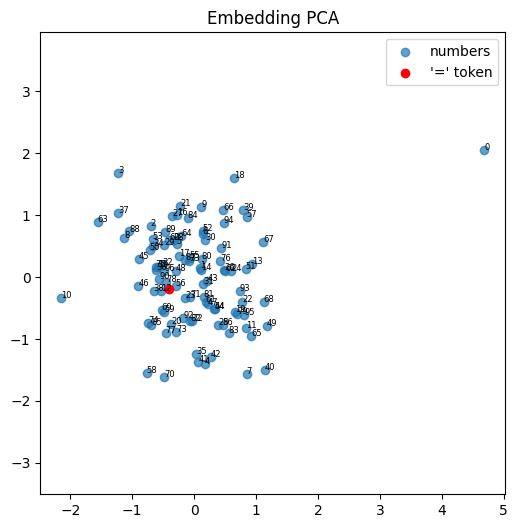

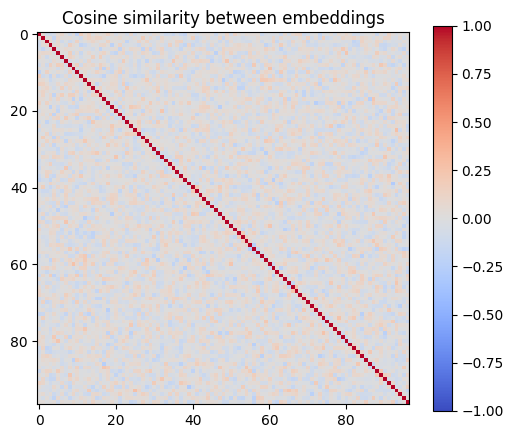

Loaded checkpoint: checkpoints_modmul_transformer/model_step50000.pt


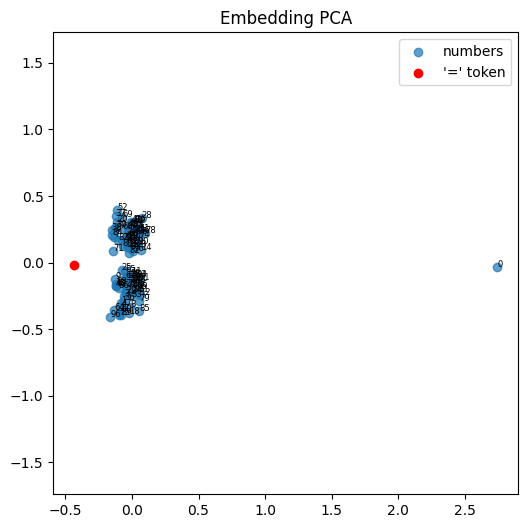

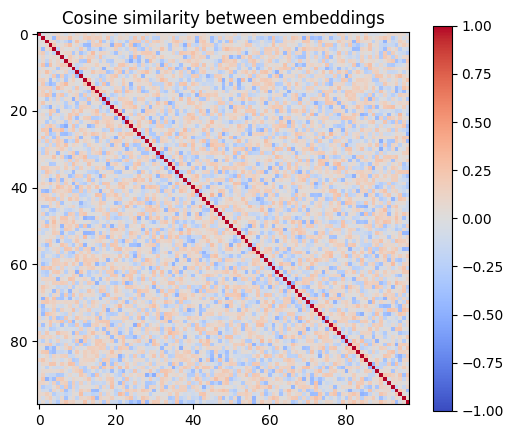

In [ ]:
def plot_embeddings_pca(model, p):
    with torch.no_grad():
        E = model.token_emb.weight.detach().cpu()
        num_E = E[:p]
        eq_E = E[p:p+1]

    E_centered = num_E - num_E.mean(dim=0)
    U, S, Vt = torch.linalg.svd(E_centered, full_matrices=False)
    pcs = U[:, :2] * S[:2]
    eq_pcs = (eq_E - num_E.mean(dim=0)) @ Vt[:2].T

    plt.figure(figsize=(6, 6))
    plt.scatter(pcs[:, 0], pcs[:, 1], alpha=0.7, label="numbers")
    plt.scatter(eq_pcs[:, 0], eq_pcs[:, 1], c="red", label="'=' token")
    for i in range(p): plt.text(pcs[i, 0], pcs[i, 1], str(i), fontsize=6)
    plt.title("Embedding PCA")
    plt.legend()
    plt.axis("equal")
    plt.show()

def plot_embedding_similarity(model, p):
    E = model.token_emb.weight.detach().cpu()[:p]
    E_norm = E / (E.norm(dim=-1, keepdim=True) + 1e-8)
    sim = E_norm @ E_norm.T
    plt.figure(figsize=(6, 5))
    plt.imshow(sim, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Cosine similarity between embeddings")
    plt.show()

for step in CHECKPOINT_STEPS:
    load_checkpoint(step)
    plot_embeddings_pca(model, PRIME_P)
    plot_embedding_similarity(model, PRIME_P)

Loaded checkpoint: checkpoints_modmul_transformer/model_step100.pt


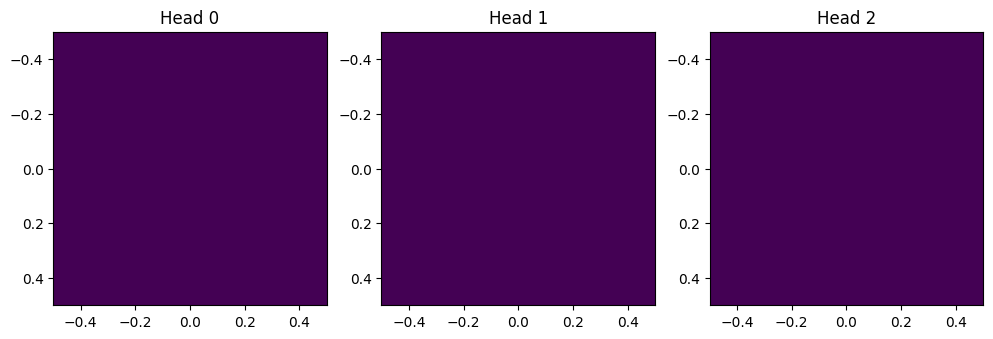

Loaded checkpoint: checkpoints_modmul_transformer/model_step500.pt


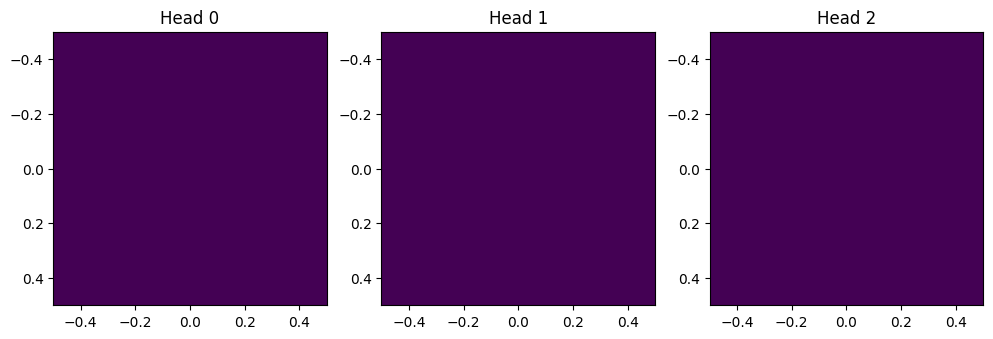

Loaded checkpoint: checkpoints_modmul_transformer/model_step1000.pt


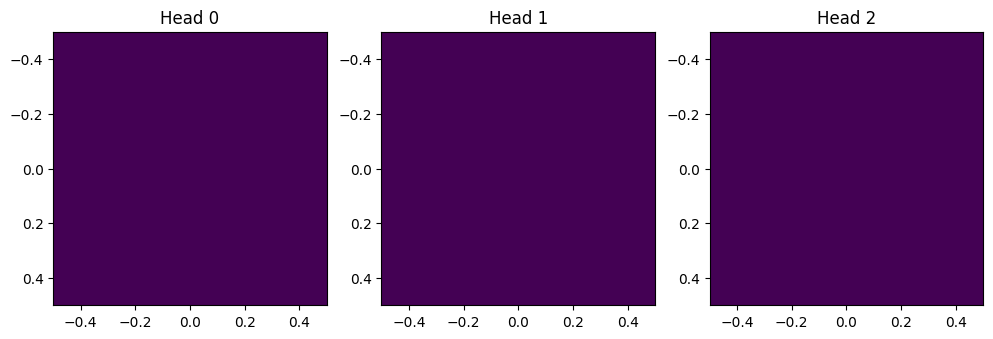

Loaded checkpoint: checkpoints_modmul_transformer/model_step4300.pt


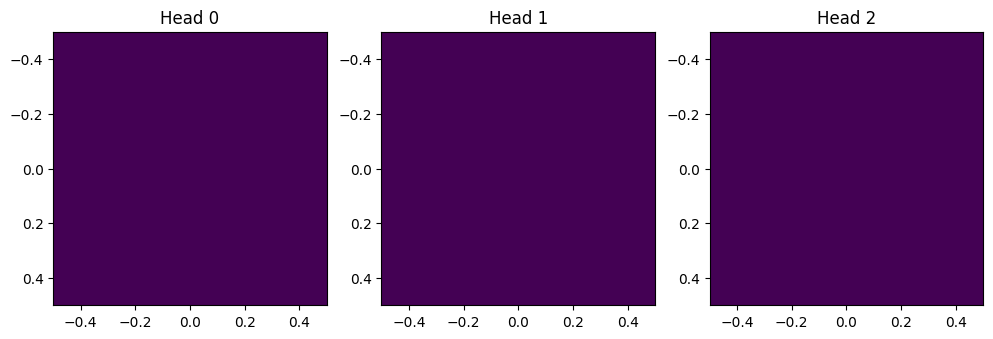

Loaded checkpoint: checkpoints_modmul_transformer/model_step5000.pt


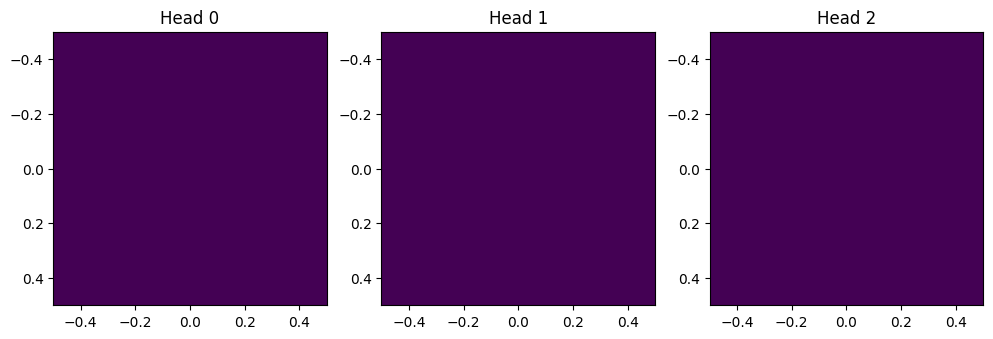

Loaded checkpoint: checkpoints_modmul_transformer/model_step10000.pt


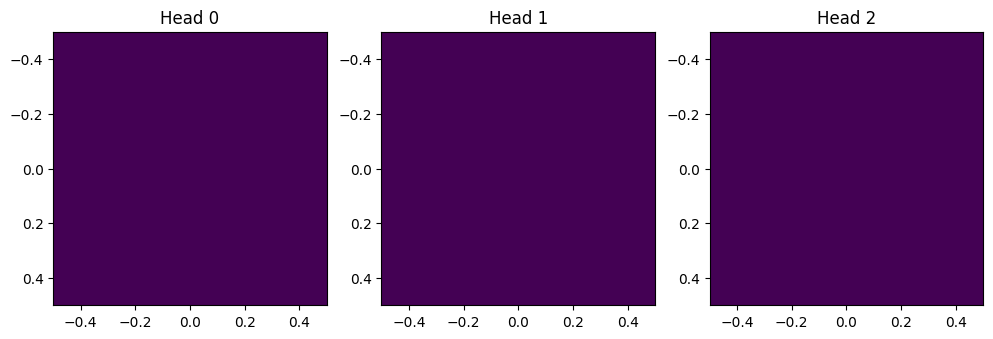

Loaded checkpoint: checkpoints_modmul_transformer/model_step50000.pt


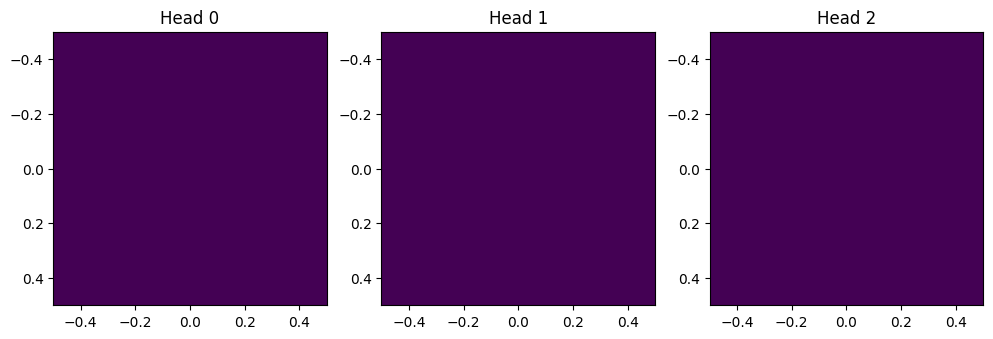

In [ ]:
def plot_attention_for_example(model, X_tokens):
    with torch.no_grad():
        x = model.token_emb(X_tokens.unsqueeze(0))
        x = x + model.pos_emb[:, :X_tokens.size(0), :]
        attn = model.encoder.layers[0].self_attn
        output, weights = attn(
            x.transpose(0, 1), x.transpose(0, 1), x.transpose(0, 1),
            need_weights=True, average_attn_weights=False
        )
    weights = weights[:, 0].cpu().numpy()  # [num_heads, seq_len, seq_len]

    plt.figure(figsize=(4 * weights.shape[0], 4))
    for h in range(weights.shape[0]):
        plt.subplot(1, weights.shape[0], h + 1)
        plt.imshow(weights[h], cmap="viridis")
        plt.title(f"Head {h}")
    plt.show()

for step in CHECKPOINT_STEPS:
    load_checkpoint(step)
    plot_attention_for_example(model, X_test[0])

In [ ]:
def run_linear_probe_at_checkpoint(step):
    load_checkpoint(step)

    h_train = get_hidden_states(model, X_train)[:, -1, :]
    h_test  = get_hidden_states(model, X_test)[:, -1, :]

    probe = nn.Linear(D_MODEL, PRIME_P).to(device)
    opt = torch.optim.Adam(probe.parameters(), lr=1e-3)

    for epoch in range(5):
        opt.zero_grad()
        loss = F.cross_entropy(probe(h_train), y_train)
        loss.backward()
        opt.step()

    with torch.no_grad():
        preds = probe(h_test).argmax(-1)
        acc = (preds == y_test).float().mean().item()

    print(f"Step {step} — Probe Accuracy: {acc:.4f}")

for step in CHECKPOINT_STEPS:
    run_linear_probe_at_checkpoint(step)

Loaded checkpoint: checkpoints_modmul_transformer/model_step100.pt
Step 100 — Probe Accuracy: 0.0091
Loaded checkpoint: checkpoints_modmul_transformer/model_step500.pt
Step 500 — Probe Accuracy: 0.0108
Loaded checkpoint: checkpoints_modmul_transformer/model_step1000.pt
Step 1000 — Probe Accuracy: 0.0120
Loaded checkpoint: checkpoints_modmul_transformer/model_step4300.pt
Step 4300 — Probe Accuracy: 0.0401
Loaded checkpoint: checkpoints_modmul_transformer/model_step5000.pt
Step 5000 — Probe Accuracy: 0.0551
Loaded checkpoint: checkpoints_modmul_transformer/model_step10000.pt
Step 10000 — Probe Accuracy: 0.0436
Loaded checkpoint: checkpoints_modmul_transformer/model_step50000.pt
Step 50000 — Probe Accuracy: 0.0560


In [ ]:
def logit_lens_at_checkpoint(step):
    load_checkpoint(step)
    h = get_hidden_states(model, X_test)

    for pos, name in zip([0, 1, 2], ["x", "y", "="]):
        with torch.no_grad():
            preds = model.out_proj(h[:, pos]).argmax(-1)
            acc = (preds == y_test).float().mean().item()
        print(f"{name} → {acc:.4f}")

for step in CHECKPOINT_STEPS:
    print(f"\n=== Logit Lens @ Step {step} ===")
    logit_lens_at_checkpoint(step)


=== Logit Lens @ Step 100 ===
Loaded checkpoint: checkpoints_modmul_transformer/model_step100.pt
x → 0.0383
y → 0.0185
= → 0.0698

=== Logit Lens @ Step 500 ===
Loaded checkpoint: checkpoints_modmul_transformer/model_step500.pt
x → 0.0504
y → 0.0159
= → 0.1110

=== Logit Lens @ Step 1000 ===
Loaded checkpoint: checkpoints_modmul_transformer/model_step1000.pt
x → 0.0542
y → 0.0181
= → 0.1547

=== Logit Lens @ Step 4300 ===
Loaded checkpoint: checkpoints_modmul_transformer/model_step4300.pt
x → 0.1679
y → 0.0826
= → 0.9033

=== Logit Lens @ Step 5000 ===
Loaded checkpoint: checkpoints_modmul_transformer/model_step5000.pt
x → 0.1925
y → 0.1073
= → 0.9718

=== Logit Lens @ Step 10000 ===
Loaded checkpoint: checkpoints_modmul_transformer/model_step10000.pt
x → 0.3542
y → 0.2373
= → 0.9977

=== Logit Lens @ Step 50000 ===
Loaded checkpoint: checkpoints_modmul_transformer/model_step50000.pt
x → 0.5579
y → 0.5591
= → 0.9982


In [ ]:
def ablate_head_at_checkpoint(step):
    load_checkpoint(step)
    baseline = (model(X_test).argmax(-1) == y_test).float().mean().item()
    print(f"\nBaseline accuracy: {baseline:.3f}")

    head_dim = D_MODEL // N_HEADS
    h = get_hidden_states(model, X_test)

    for i in range(N_HEADS):
        h2 = h.clone()
        h2[:, :, i * head_dim:(i + 1) * head_dim] = 0
        with torch.no_grad():
            preds = model.out_proj(h2[:, -1]).argmax(-1)
            acc = (preds == y_test).float().mean().item()
        print(f"Head {i} ablated → accuracy: {acc:.4f}")

for step in CHECKPOINT_STEPS:
    ablate_head_at_checkpoint(step)

Loaded checkpoint: checkpoints_modmul_transformer/model_step100.pt

Baseline accuracy: 0.070
Head 0 ablated → accuracy: 0.0606
Head 1 ablated → accuracy: 0.0612
Head 2 ablated → accuracy: 0.0598
Head 3 ablated → accuracy: 0.0588
Loaded checkpoint: checkpoints_modmul_transformer/model_step500.pt

Baseline accuracy: 0.111
Head 0 ablated → accuracy: 0.0952
Head 1 ablated → accuracy: 0.0976
Head 2 ablated → accuracy: 0.0953
Head 3 ablated → accuracy: 0.0906
Loaded checkpoint: checkpoints_modmul_transformer/model_step1000.pt

Baseline accuracy: 0.155
Head 0 ablated → accuracy: 0.1325
Head 1 ablated → accuracy: 0.1318
Head 2 ablated → accuracy: 0.1306
Head 3 ablated → accuracy: 0.1315
Loaded checkpoint: checkpoints_modmul_transformer/model_step4300.pt

Baseline accuracy: 0.903
Head 0 ablated → accuracy: 0.8216
Head 1 ablated → accuracy: 0.8335
Head 2 ablated → accuracy: 0.8365
Head 3 ablated → accuracy: 0.8105
Loaded checkpoint: checkpoints_modmul_transformer/model_step5000.pt

Baseline accu

In [ ]:
@interact(i=IntSlider(min=0, max=len(CHECKPOINT_STEPS)-1, value=0))
def view_embeddings(i):
    step = CHECKPOINT_STEPS[i]
    load_checkpoint(step)
    plot_embeddings_pca(model, PRIME_P)
    plot_embedding_similarity(model, PRIME_P)

@interact(i=IntSlider(min=0, max=len(CHECKPOINT_STEPS)-1, value=0))
def view_attention(i):
    step = CHECKPOINT_STEPS[i]
    load_checkpoint(step)
    plot_attention_for_example(model, X_test[0])

@interact(i=IntSlider(min=0, max=len(CHECKPOINT_STEPS)-1, value=0))
def view_logit_lens(i):
    step = CHECKPOINT_STEPS[i]
    print(f"\n=== Logit Lens @ Step {step} ===")
    logit_lens_at_checkpoint(step)

@interact(i=IntSlider(min=0, max=len(CHECKPOINT_STEPS)-1, value=0))
def view_ablation(i):
    step = CHECKPOINT_STEPS[i]
    ablate_head_at_checkpoint(step)

interactive(children=(IntSlider(value=0, description='i', max=6), Output()), _dom_classes=('widget-interact',)…

interactive(children=(IntSlider(value=0, description='i', max=6), Output()), _dom_classes=('widget-interact',)…

interactive(children=(IntSlider(value=0, description='i', max=6), Output()), _dom_classes=('widget-interact',)…

interactive(children=(IntSlider(value=0, description='i', max=6), Output()), _dom_classes=('widget-interact',)…